<a href="https://colab.research.google.com/github/NeSma237/collaborative-filtering-recommender/blob/main/notebooks/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir collaborative-filtering-recommender
!cd collaborative-filtering-recommender
!mkdir data notebooks src results
!touch README.md requirements.txt
!touch README.md requirements.txt

In [5]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

import pandas as pd

ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', sep='|', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')
users = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

--2025-04-25 17:44:53--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.53MB/s    in 0.8s    

2025-04-25 17:44:54 (5.53 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os
from surprise.model_selection import train_test_split


In [8]:
# For the ratings data:
ratings = pd.read_csv('ml-100k/u.data', # Changed the file path to 'ml-100k/u.data'
                     sep='\t',
                     names=['user_id', 'item_id', 'rating', 'timestamp'])

# For the movies data:
movies = pd.read_csv('ml-100k/u.item', # Changed the file path to 'ml-100k/u.item'
                    sep='|',
                    encoding='latin-1',
                    header=None)  # Add column names as needed
movies.columns = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# For the users data:
users = pd.read_csv('ml-100k/u.user', # Changed the file path to 'ml-100k/u.user'
                   sep='|',
                   names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
movies = movies.rename(columns={'movie_id': 'item_id'})

# Now merge the data
try:
    # Merge ratings with movies
    movie_ratings = pd.merge(ratings, movies, on='item_id')

    # Then merge with users
    full_data = pd.merge(movie_ratings, users, on='user_id')

    print("Data merged successfully!")
    print("\nFirst few rows of merged data:")
    print(full_data.head())

    # Save the merged data
    full_data.to_csv('data/merged_data.csv', index=False)

except Exception as e:
    print(f"Error merging data: {e}")
    print("\nCurrent column names:")
    print("Ratings:", ratings.columns.tolist())
    print("Movies:", movies.columns.tolist())
    print("Users:", users.columns.tolist())

Data merged successfully!

First few rows of merged data:
   user_id  item_id  rating  timestamp                       title  \
0      196      242       3  881250949                Kolya (1996)   
1      186      302       3  891717742    L.A. Confidential (1997)   
2       22      377       1  878887116         Heavyweights (1994)   
3      244       51       2  880606923  Legends of the Fall (1994)   
4      166      346       1  886397596         Jackie Brown (1997)   

  release_date  video_release_date  \
0  24-Jan-1997                 NaN   
1  01-Jan-1997                 NaN   
2  01-Jan-1994                 NaN   
3  01-Jan-1994                 NaN   
4  01-Jan-1997                 NaN   

                                            IMDb_URL  unknown  Action  ...  \
0    http://us.imdb.com/M/title-exact?Kolya%20(1996)        0       0  ...   
1  http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...        0       0  ...   
2  http://us.imdb.com/M/title-exact?Heavyweights%...      

In [9]:
print("Ratings columns:", ratings.columns.tolist())
print("Movies columns:", movies.columns.tolist())
print("Users columns:", users.columns.tolist())

Ratings columns: ['user_id', 'item_id', 'rating', 'timestamp']
Movies columns: ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
Users columns: ['user_id', 'age', 'gender', 'occupation', 'zip_code']


In [10]:
#Check for Missing Values
print("Missing Values in Ratings:", ratings.isnull().sum().sum())
print("Missing Values in Movies:", movies.isnull().sum().sum())
print("Missing Values in Users:", users.isnull().sum().sum())

Missing Values in Ratings: 0
Missing Values in Movies: 1686
Missing Values in Users: 0


In [11]:
data = pd.merge(ratings, movies, on='item_id')
print("\nMerged Data (Ratings + Movies):")
print(data.head())


Merged Data (Ratings + Movies):
   user_id  item_id  rating  timestamp                       title  \
0      196      242       3  881250949                Kolya (1996)   
1      186      302       3  891717742    L.A. Confidential (1997)   
2       22      377       1  878887116         Heavyweights (1994)   
3      244       51       2  880606923  Legends of the Fall (1994)   
4      166      346       1  886397596         Jackie Brown (1997)   

  release_date  video_release_date  \
0  24-Jan-1997                 NaN   
1  01-Jan-1997                 NaN   
2  01-Jan-1994                 NaN   
3  01-Jan-1994                 NaN   
4  01-Jan-1997                 NaN   

                                            IMDb_URL  unknown  Action  ...  \
0    http://us.imdb.com/M/title-exact?Kolya%20(1996)        0       0  ...   
1  http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...        0       0  ...   
2  http://us.imdb.com/M/title-exact?Heavyweights%...        0       0  ...   
3  ht

In [12]:
#Basic Statistics
print("\nRating Statistics:")
print(data['rating'].describe())

print("\nNumber of Unique Users:", data['user_id'].nunique())
print("Number of Unique Movies:", data['item_id'].nunique())


Rating Statistics:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Number of Unique Users: 943
Number of Unique Movies: 1682


<ipython-input-15-0bee31e0cea3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=data, palette='viridis')


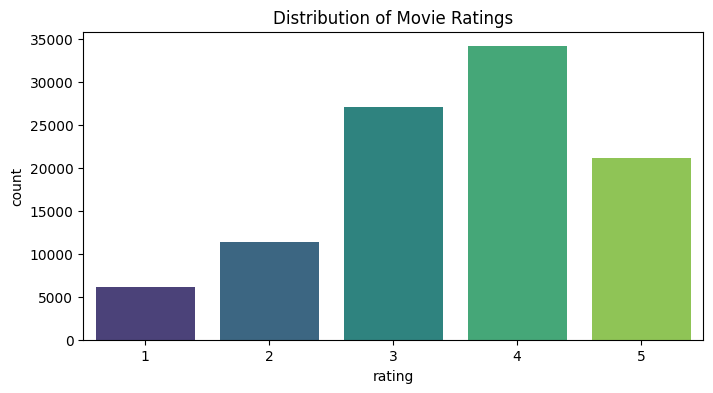

In [15]:
#Distribution of Ratings
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=data, palette='viridis')
plt.title("Distribution of Movie Ratings")
plt.show()

<ipython-input-16-27e2560dbecb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='magma')


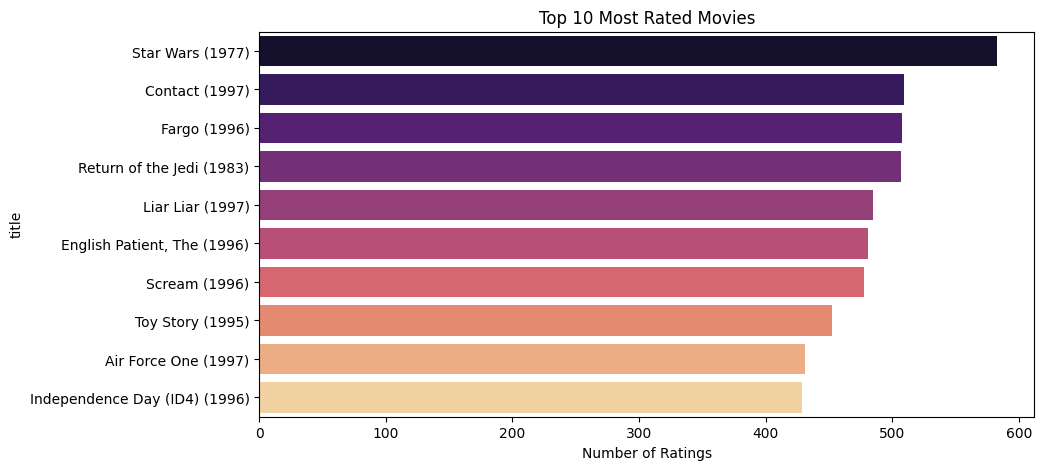

In [16]:
#Top 10 Most Rated Movies

top_movies = data['title'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='magma')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.show()

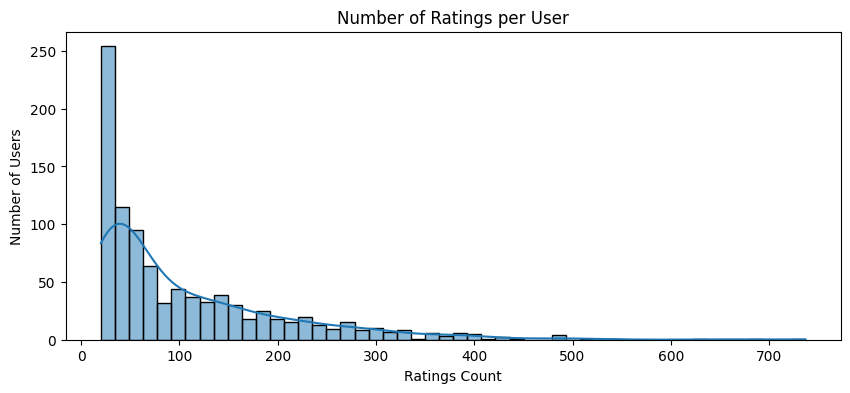

In [17]:
#User Rating Frequency

user_activity = data['user_id'].value_counts()
plt.figure(figsize=(10, 4))
sns.histplot(user_activity, bins=50, kde=True)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Number of Users")
plt.show()

In [18]:
user_item_matrix = data.pivot_table(
    index='user_id',
    columns='title',
    values='rating',
    fill_value=0
)

print("\nUser-Item Matrix Shape:", user_item_matrix.shape)
print("Sample (First 5 Users, First 5 Movies):")
print(user_item_matrix.iloc[:5, :5])


User-Item Matrix Shape: (943, 1664)
Sample (First 5 Users, First 5 Movies):
title    'Til There Was You (1997)  1-900 (1994)  101 Dalmatians (1996)  \
user_id                                                                   
1                              0.0           0.0                    2.0   
2                              0.0           0.0                    0.0   
3                              0.0           0.0                    0.0   
4                              0.0           0.0                    0.0   
5                              0.0           0.0                    2.0   

title    12 Angry Men (1957)  187 (1997)  
user_id                                   
1                        5.0         0.0  
2                        0.0         0.0  
3                        0.0         2.0  
4                        0.0         0.0  
5                        0.0         0.0  
